# Chapter 2: Multi-Armed Bandits

### 2.1

When $\epsilon=0.5$, we'll act greedily 50% of the time, and select a random exploratory action 50% of the time. In the exploratory case, the greedy action still gets picked 50% of the time because there are two only actions available.

So overall the greedy action is picked 75% of the time: $(0.5)(1) + (0.5)(0.5) = 0.75$.

### 2.2: Bandit Example

Every action could possibly have been selected randomly as an exploratory action. Timesteps 4 and 5 were definitely exploratory because the selected actions did not have maximal sample-average action-value estimates:

- $A_4 = 2$: $Q^4(2) = \frac{1-2}{2} < Q^4(3) = 0$
- $A_5 = 3$: $Q^5(3) = 0 < Q^5(2) = \frac{1-2+2}{3}$

### 2.3

In the long run, the $\epsilon=0.01$ method will win on average.

The greedy ($\epsilon=0$) method will remain stuck picking the same action, which (using the plot) is the optimal action about 35% of the time and getting an average reward-per-step of about 1.

An $\epsilon$-greedy method will eventually explore all actions enough to be confident in their average values, so the greedy action is guaranteed to be the optimal one. It will pick the optimal action $(1 - \epsilon) + \frac{\epsilon}{10}$ of the time (the latter term coming from the 1/10 chance to hit the optimal action on an exploratory move). Its expected return will be about $1.55 (1 - \epsilon)$, because the expected reward from picking the optimal action is equal to the best-possible reward-per-step and the expected reward from picking a random action is 0 (the unconditional prior mean of an arm).

So, on average the $\epsilon=0.1$ method will select the optimal action 91% of the time and get an expected return of about 1.4, while the $\epsilon=0.01$ method will select the optimal action 99.1% of the time and get an expected return of about 1.53. In the long-time limit, it's best to explore the smallest nonzero amount possible to spend more time exploiting without getting stuck on suboptimal actions.

### 2.4

\\(
\begin{align*}
Q_{n+1} &= Q_n + \alpha_n (R_n - Q_n) \\
 &= \alpha_n R_n + (1 - \alpha_n) Q_n \\
 &= \alpha_n R_n + (1 - \alpha_n) \left( \alpha_{n-1} R_{n-1} + (1 - \alpha_{n-1}) Q_{n-1} \right) \\
 &= \alpha_n R_n + \alpha_{n-1} (1 - \alpha_n) R_{n-1} + \alpha_{n-2} (1 - \alpha_{n-1})(1-\alpha_{n-2})R_{n-2} + \ldots + (1-\alpha_1)(1-\alpha_2) \ldots (1 - \alpha_n) Q_1 \\
 &= \left( \prod_{j=1}^n (1-\alpha_j) \right) Q_1 + \sum_{i=1}^n \left( \alpha_i \prod_{j=i+1}^n (1 - \alpha_j) \right) R_i
\end{align*}
\\)

# TODO: 2.6 - 2.10, 2.11

### Programming: 2.5 and 2.11

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def simulate(
    # Environment
    drift=0.0,
    n_arms=10,
    n_timesteps=1_000,
    n_runs=2_000,
    # Algorithm
    constant_step_size=None, # None -> sample average
    epsilon=0.0,
    optimism=0.0,
    ucb_c=0.0, # 0 -> UCB is unused
):
    arm_means = np.random.normal(size=(n_runs, n_arms)) # Q_true[:, a]
    
    q_estimates = np.full((n_runs, n_arms), optimism) # Q[:, a]
    visits = np.zeros((n_runs, n_arms)) # N[:, a]
    
    step_mean_reward = np.zeros(n_timesteps)
    step_frac_was_optimal = np.zeros(n_timesteps)
    
    idx_runs = np.arange(n_runs)
    
    for t in range(n_timesteps):
        # Update the environment
        arm_means += np.random.normal(scale=drift, size=(n_runs, n_arms))
        
        # Select greedy or UCB actions
        if ucb_c == 0.0:
            greedy_actions = q_estimates.argmax(axis=1)
        else:
            # When an arm has 0 visits, UCB will be infinite and we're guaranteed to visit that arm
            with np.errstate(divide='ignore'):
                # NOTE: the offset t+2 here doesn't matter much, but prevents "0 / 0" issues on timestep 0
                ucb = q_estimates + ucb_c * np.sqrt(np.divide(np.log(t+2), visits)) # [n_runs, n_arms]
            
            greedy_actions = ucb.argmax(axis=1)
        
        # epsilon-greedy: replace some greedy actions with random actions
        random_actions = np.random.randint(0, n_arms, n_runs)
        explore_mask = np.random.rand(n_runs) < epsilon
        actions = np.where(explore_mask, random_actions, greedy_actions) # [n_runs]
        
        # For each run, sample a reward from the environment based on the action selected
        mean_rewards_for_actions = arm_means[idx_runs, actions]
        rewards = np.random.normal(loc=mean_rewards_for_actions) # R ~ N(mean[a], 1)
        was_optimal = actions == arm_means.argmax(1)
        
        # Update the algorithm's memory
        visits[idx_runs, actions] += 1
        step_size = constant_step_size or 1 / visits[idx_runs, actions] # Sample average: c = 1 / N[a]
        q_estimates[idx_runs, actions] += step_size * (rewards - q_estimates[idx_runs, actions]) # Q[a] <- Q[a] + c * (R - Q[a])
        
        # Record results
        step_mean_reward[t] = rewards.mean()
        step_frac_was_optimal[t] = was_optimal.mean()
    
    return step_mean_reward, step_frac_was_optimal

def plot_over_time(run_kwargs, **global_kwargs):
    fig, [ax_1, ax_2] = plt.subplots(nrows=2, sharex=True)
    ax_1.set_ylabel('Average reward')
    ax_2.set_ylabel('% Optimal action')
    ax_2.set_xlabel('Steps')
    
    for label, kwargs in run_kwargs:
        reward, optimal = simulate(**kwargs, **global_kwargs)
        timesteps = np.arange(reward.shape[0])
        ax_1.plot(timesteps, reward)
        ax_2.plot(timesteps, optimal, label=label)
        
    ax_2.legend()
    return fig

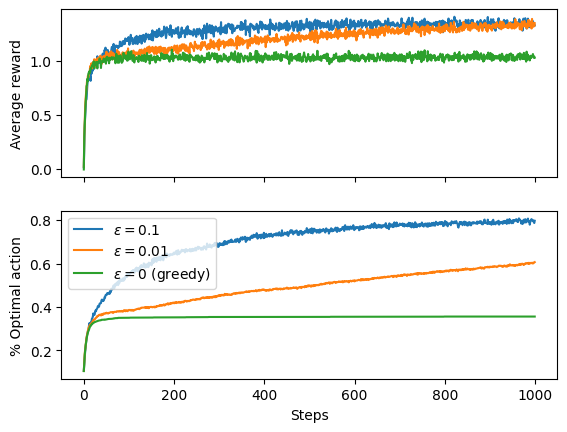

In [2]:
# Reproduce figure 2.2
plot_over_time([
    ("$\epsilon=0.1$", {"epsilon": 0.1}),
    ("$\epsilon=0.01$", {"epsilon": 0.01}),
    ("$\epsilon=0$ (greedy)", {}),
]).show()

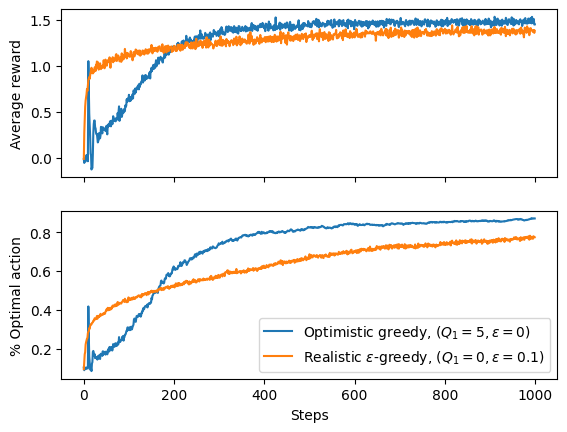

In [3]:
# Reproduce figure 2.3
plot_over_time([
    ("Optimistic greedy, ($Q_1 = 5, \epsilon=0$)", {"optimism": 5.0, "constant_step_size": 0.1}),
    ("Realistic $\epsilon$-greedy, ($Q_1 = 0, \epsilon=0.1$)", {"epsilon": 0.1, "constant_step_size": 0.1}),
]).show()

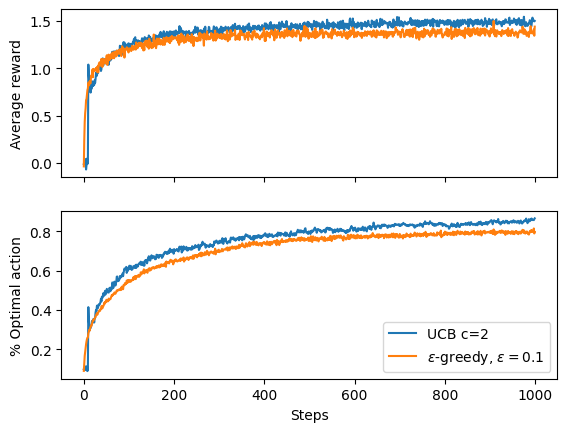

In [4]:
# Reproduce figure 2.4
plot_over_time([
    ("UCB c=2", {"ucb_c": 2.0}),
    ("$\epsilon$-greedy, $\epsilon=0.1$", {"epsilon": 0.1}),
]).show()

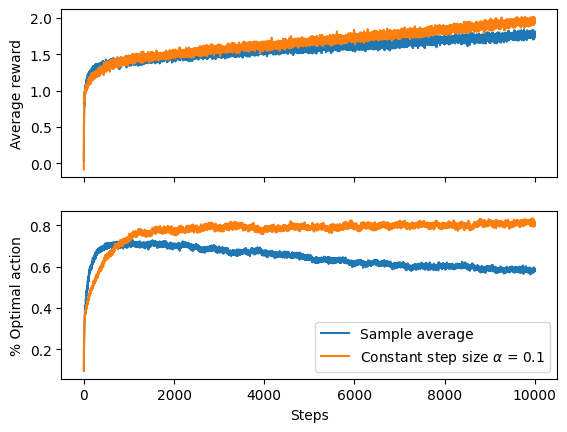

In [5]:
# Exercise 2.5
plot_over_time([
    ("Sample average", {"epsilon": 0.1}),
    (r"Constant step size $\alpha$ = 0.1", {"epsilon": 0.1, "constant_step_size": 0.1}),
], drift=0.01, n_timesteps=10_000).show()